In [1]:
!pip install pandas numpy sklearn matplotlib tensorly openpyxl keras scipy tensorflow seaborn

In [ ]:
!git clone https://github.com/DelisLab/Machine-Learning-Tutorials.git

In [1]:
##Here is the required python functions to run this notebook
##The main packages used are sklearn, tensorly, pandas, matplotlib and numpy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF
import tensorly as tl
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor
import scipy.integrate as integrate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Shape of the matrix (across timepoints):  (32000, 9)
Shape of matrix reshaped (across trials):  (640, 50, 9)
Shape of matrix (across muscles)  (50, 5760)


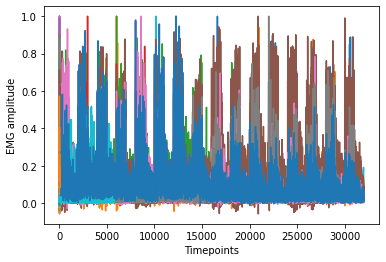

In [2]:
##Data preperation

#The first step in any analytical approach is to get to know your data. For this sample sheet, we are using a dataset 
#of nine EMG channels recorded across the right arm and torso during point-to-point backward and forwards reaching movements 
#(see https://doi.org/10.1152/jn.00245.2013 for details on the data collection). 
#In the following code, we will import this data for a single subject across 640 trials 
#(320 in the forward direction, 320 in the backwards direction) using the pandas package.

X=pd.read_excel(r'/content/Machine-Learning-Tutorials/Machine_Learning_tutorials/EMG_daven1.xlsx')

#This matrix is formatted across time (i.e. rows=timepointsxtrials, columns=EMG channels)
#To find the dimensions of this matrix, simply add the following term at the end of the variable:

print('Shape of the matrix (across timepoints): ',X.shape)

#Inspect the data on a trial-to-trial basis by reshaping the 2D matrix into a 3D tensor. Each trial consists of 50
#timepoints, therefore we need to produce a 640 trial x 50 timepoint x 9 muscle tensor in the following way:

X_tensor=X.values.reshape(640,50,9)
print('Shape of matrix reshaped (across trials): ',X_tensor.shape)

#We can also reshape this tensor back to a 2D matrix but across muscles instead of across time
#We do so by swapping the axes in the above tensor so that timepoints are along the first dimension and then
#converting the tensor back to a 2D matrix as shown below:

X_Temporal=X_tensor.transpose(1,0,2).reshape(50,640*9)
print('Shape of matrix (across muscles) ',X_Temporal.shape)

#Here you can plot a single trial to inspect the quality and interpretability of the EMG recordings 
#using the matplotlib library:
trial=10
plt.plot(X_tensor[trial,:,:])
plt.xlabel('Timepoints')
plt.ylabel('EMG amplitude')

#Q1) Can you plot the across timepoints and across muscles matrices below?
#A1.1) Across Timepoints
plt.plot(X)
#A1.2) Across Muscles
plt.plot(X_tensor.transpose(1,0,2).reshape(50,640*9))


#Q2) Can you plot just a specific timepoint/muscle from these matrices also?

#A2.1) Specific timepoint
plt.plot(X.values[5,:])
plt.plot(X_tensor.transpose(1,0,2).reshape(50,640*9)[5,:])
#A2.2) Specific Muscles
plt.plot(X.values[:,5])
plt.plot(X_tensor.transpose(1,0,2).reshape(50,640*9)[:,5])



In [3]:
#It is important when interpreting the data that it is put in the context of the motor behavior being performed.
#So now we will import three task variables that categorise the above data based on the following events:
    #TASK = All reaching movements in both directions and at fast and slow speeds.
        #(1-4= forward reaching at a slow speed, 5-8= backward reaching at a slow speed, 9-12=forward reaching at a fast pace,
        #13-16= backward reaching at a fast pace
    #Speed = Fast or slow reaching speeds.
    #Direction = Forward or backwards direction

Y=pd.read_excel('/content/Machine-Learning-Tutorials/Machine_Learning_tutorials/trg.xlsx')


task=Y.iloc[:,1]

In [4]:
#Conditional Indexing using numpy where function...
#Note the [0] at the end...
np.where((Y['Speed']==0) & (Y['Direction']==0))[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238], dtype=int64)

Fast trials in the forward reaching direction selected..
Muscles included:  ['BR', 'BI', 'TM']
Averaging across Muscles


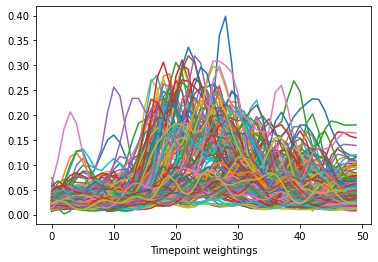

In [10]:
#The following function extracts reaching task trials in a specific direction and at a specific speed. Along with this
#you can extract specific EMG channels and conduct an averaging either across trials or across timepoints

#Here are the input variables for the function

    #Speed: 1 for fast and 0 for slow speed
    #Direction: 0 for forward and 1 for backward reaching direction
    #Muscle: integers ranging from [1-9] for the following muscles respectively: 
        #[Finger extensor, brachioradialis, biceps brachii,triceps medialis, triceps lateralis, anterior deltoid, posterior deltoid, pectoralis major, latissimus dorsi].
    #Average: 0=Across trials, 1=Across Timepoints, 2=Across muscles

def func_data(Speed, Direction,Muscle, Average):
    

    #Conditional indexing of the EMG matrix in tensor formate for specific speed and direction trials
    #Here we use the numpy function where..Note the extra bracket [0] at the end, this is necessary as the output is an array
    #of arrays which may have multiple relevant structures depending on the number of conditions
    if Speed==0 and Direction==0:
        trial=X_tensor[np.where((Y['Speed']==0) & (Y['Direction']==0))[0],:,:]
        print('Fast trials in the forward reaching direction selected..')
    elif Speed==1 and Direction==0:
        trial=X_tensor[np.where((Y['Speed']==1) & (Y['Direction']==0))[0]]
        print('Slow trials in the forward reaching direction selected...')
    elif Speed==0 and Direction==1:
        trial=X_tensor[np.where((Y['Speed']==0) & (Y['Direction']==1))[0]]
        print('Fast trials in the backward reaching direction selected...')
    else:
        trial=X_tensor[np.where((Y['Speed']==1) & (Y['Direction']==1))[0]]
        print('Slow trials in the backward reaching direction selected...')
    
    
    #What muscles have been selected
    print('Muscles included: ', X.columns[Muscle].tolist())
    
    #Extract the muscles of interest
    trial=trial[:,:,Muscle]
    
    
    if Average==0:
        trial=trial.mean(axis=0)
    elif Average==1:
        trial=trial.mean(axis=1)
    elif Average==2:
        trial=trial.mean(axis=2)
        
    if Average==0:
        print('Averaging across trials')
        plt.xlabel('Timepoints')
        plt.plot(trial)
    elif Average==1:
            print('Averaging across Timepoints')
            pd.DataFrame(trial.T).plot(kind='bar',legend=False).set_xticklabels(X.columns[Muscle])
            plt.xlabel('Muscle weightings')
    elif Average==2:
        print('Averaging across Muscles')
        pd.DataFrame(trial.T).plot(kind='line',legend=False)
        plt.xlabel('Timepoint weightings')

    
#Adjust the below input values to view different outputs   

func_data(Speed=0,Direction=0,Muscle=[1,2,3],Average=2)

In [11]:
#Inspect the function above and see if you can you get the trial-averaged data for a specific timepoint?
    #Hint: To index all the timepoints and muscles in a specific trial of a 3D matrix, you must index like '[x,:,:]'
X_tensor.mean(axis=0)


    
#Q3) Examine the code in the function above and see if you can find the time-averaged data for a specific timepoint?
X_tensor.mean(axis=1)

#Q4) How can you confirm the shape of the reshaped matrix? Show this below..

X_tensor.mean(axis=1).shape


(640, 9)

In [12]:
#Next, we need to specify the number of components we wish to extract during the dimensionality reduction process. This
#step is vital as too few or too many extracted components gives a suboptimal representation of the original matrix. The
#appropriate model-rank is notoriously difficult to empirically determine (see doi: 10.1007/s00421-021-04604-9 for details),
#and so here we will start with an arbitrary number of your choice and demonstrate an empirical method later on....

##Specify the model rank you want to investigate using this variable:
num_components=3


Input matrix shape:  (32000, 9)
Explained variance ratio:  [0.40465793 0.21460524 0.11688571]
Singular values:  [28.13084483 20.4860819  15.11887414]
Explained variance ratio:  [0.29495799 0.19411339 0.09828448]
Singular values:  [22.43048925 18.19643921 12.94795342]


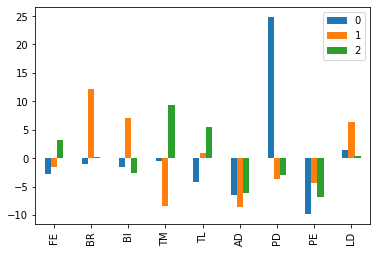

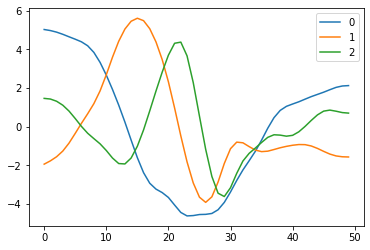

In [13]:
## Principal component analysis
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


##Q7) PCA is a dimensionality reduction method implemented on 2D matrices, we will use the following matrix as input to
#extract spatial components


print('Input matrix shape: ',X.shape)


model_pca=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model_pca.fit(X.T)
print('Explained variance ratio: ',model_pca.explained_variance_ratio_)
print('Singular values: ', model_pca.singular_values_)

X_pca=model_pca.transform(X.T)

pd.DataFrame(X_pca).plot(kind='bar').set_xticklabels(X.columns)

#Here is how we can do this in the temporal domain:
X_temp=X.values.reshape(640,50,9).transpose(1,0,2).reshape(50,640*9)
model_pca=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model_pca.fit(X_temp)
print('Explained variance ratio: ',model_pca.explained_variance_ratio_)
print('Singular values: ', model_pca.singular_values_)

X_pca=model_pca.transform(X_temp)

pd.DataFrame(X_pca).plot(kind='line')
plt.show()

Components:  [[ 4.27881228e-05  5.63461292e-05  6.04092344e-05 ...  4.24257148e-06
   8.42023321e-06  9.20874234e-06]
 [ 4.97238328e-05  3.95197352e-05  6.57289021e-05 ... -2.11459638e-06
  -1.57937590e-05 -1.79934384e-05]
 [ 2.37288474e-05  5.40601951e-05  6.12507631e-05 ...  6.19524554e-06
   8.29207753e-06  8.75264519e-06]]
Mixing values:  [[ 0.0184685   0.01166304  0.01022954]
 [ 0.02129208  0.00748011  0.0325162 ]
 [ 0.02328541  0.0133988   0.03566358]
 ...
 [ 0.00123287 -0.00081303  0.00441405]
 [ 0.00244501 -0.00411412  0.00657774]
 [ 0.00268025 -0.00464995  0.00700749]]
Mean values:  [0.02025492 0.02554836 0.02839931 ... 0.01769472 0.01687676 0.01683082]
Components:  [[ 2.00693571e-04 -4.04041875e-05  4.39305282e-04 ...  2.78046725e-04
  -5.13277184e-05  1.14542931e-04]
 [ 2.92184643e-05  7.99901683e-05  4.13418200e-04 ...  1.59061932e-04
   1.16749685e-05  8.21288412e-05]
 [-8.95478146e-04 -1.16528948e-04 -3.77417129e-05 ... -1.24345846e-04
   7.67723374e-06 -6.02572391e-05]]


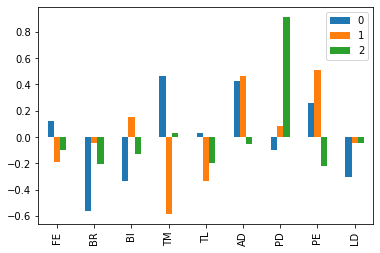

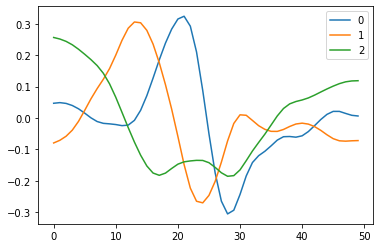

In [14]:
#Independent component analysis
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

##Q7) Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on ICA...


model_ica=FastICA(n_components=num_components, algorithm='parallel', whiten=True, 
        fun='logcosh', fun_args=None, max_iter=200, 
        tol=0.0001, w_init=None, random_state=None)


model_ica.fit(X.T)
print('Components: ',model_ica.components_)
print('Mixing values: ', model_ica.mixing_)
print('Mean values: ', model_ica.mean_)
X_ica=model_ica.transform(X.T)
pd.DataFrame(X_ica).plot(kind='bar').set_xticklabels(X.columns)

X_temp=X.values.reshape(640,50,9).transpose(1,0,2).reshape(50,640*9)
model_ica=FastICA(n_components=num_components, algorithm='parallel', whiten=True,
fun='logcosh', fun_args=None, max_iter=200,
tol=0.0001, w_init=None, random_state=None)
model_ica.fit(X_temp)
print('Components: ',model_ica.components_)
print('Mixing values: ', model_ica.mixing_)
print('Mean values: ', model_ica.mean_)
X_ica=model_ica.transform(X_temp)
pd.DataFrame(X_ica).plot(kind='line')
plt.show()


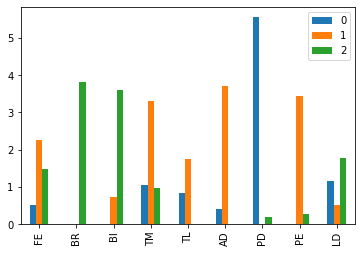

Timepoint specific activation coefficient : [[0.00445753 0.0087293  0.00891719 ... 0.00318417 0.00353221 0.00361545]
 [0.00691987 0.00730602 0.00995962 ... 0.00413595 0.00394586 0.00393877]
 [0.00267341 0.00312425 0.00352195 ... 0.00562449 0.00492552 0.00482269]]


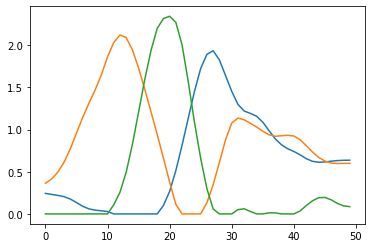

Timepoint specific activation coefficient : [[0.09519026 0.01793609 0.01270044 ... 0.02148107 0.00727427 0.00314824]
 [0.05579619 0.02273862 0.07686776 ... 0.04255542 0.00858382 0.01132671]
 [0.09198873 0.01027585 0.03246118 ... 0.03026622 0.0006698  0.01086567]]


In [15]:
##Non-negative matrix factorisation
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html



##Q8) Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on NMF...



model_NMF=NMF(n_components=num_components,solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False)

    #Below is an implementation of NNMF in the spatial domain (i.e. relative weightings in muscle activity across time)






W_spatial = model_NMF.fit_transform(abs(X).T)
H_spatial = model_NMF.components_

pd.DataFrame(W_spatial).plot(kind='bar').set_xticklabels(X.columns)
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)



#Q5) We can also investigate the predominant patterns in the temporal domain (i.e. covariation in EMG activity across muscles).
#The data first needs to be manipulated so as to capture this across muscle dimension...
#This involves the reshaping discussed earlier...Can you implement this in the space below?

X_temp=X.values.reshape(640,50,9).transpose(1,0,2).reshape(50,640*9)
W_spatial = model_NMF.fit_transform(abs(X_temp))
H_spatial = model_NMF.components_
plt.plot(W_spatial)
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)

##Here are the hyperparameters for NNMF that you can adjust, press shift+tab while inside the function to see the options
##in detail

# 'init': The method to initialise the extracted components
# 'solver': Numerical solver to use for the optimisation problem
# 'beta_loss': the loss function
# 'tol': the Tolerance of the stopping criterion
# 'max_iter': Maximum number of iterations during timing out
# 'alpha': a constant that adjust the influence of the regularisations terms in the loss function
# 'l1_ratio': a mixing parameter that allows one to adjust the regularisation term towards either L1 or L2 penaly terms


##Q6 What is the effect of adjusting each of these hyperparameters on the output???




PARAFAC output structure:  (weights, factors) : rank-3 CPTensor of shape (640, 50, 9) 


<AxesSubplot:>

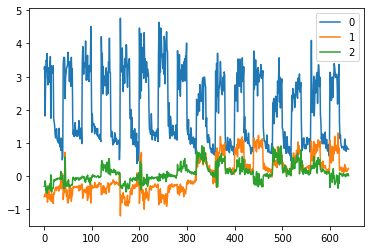

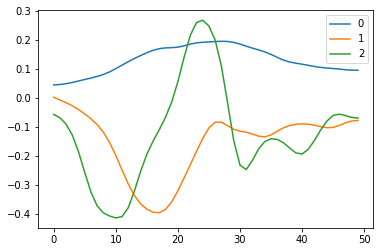

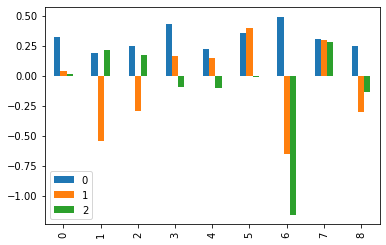

In [16]:
##Tensor decompositions: PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a tensor decomposition method known as PARAFAC or Canonical Decomposition

#As before, we begin with a tensor, we also need to set it to a data type specific to the Tensorly package as shown below:
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Using a function provided by the Tensorly package, we implement the PARAFAC decomposition at a model-rank
#equal to the value contained by the num_components variable
factors_para = parafac(X_tensor ,rank=num_components)

#The output is a structure holding the following arrays:
print('PARAFAC output structure: ', factors_para)

#To index the substructures of this PARAFAC decomposition, you can do so in the following manner:

factors_para[0]   #Weights (Note. these are all equal to 1, see the user guide to adjust the weighting of each dimension) 
factors_para[1]   #Factors

#The factors sub-structure is of particular interest here as it contains the low-dimensional representations of the original
#dataset across trials, across timepoints and across muscles

pd.DataFrame(factors_para[1][0]).plot()
pd.DataFrame(factors_para[1][1]).plot()
pd.DataFrame(factors_para[1][2]).plot(kind='bar')

<AxesSubplot:>

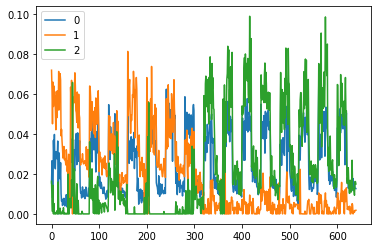

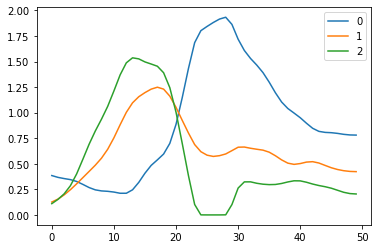

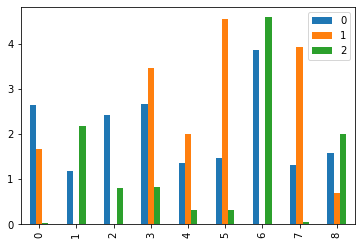

In [37]:
##Tensor decompositions: Non-negative-PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a PARAFAC decomposition that is orthogonally constrained:

#As before, we begin with a tensor, we also need to set it to a data type specific to the Tensorly package as shown below:
X_tensor=tl.tensor(X.values.reshape(640,50,9))


#Using a function provided by the Tensorly package, we implement the Non-negative PARAFAC decomposition:
factors_nnpara = non_negative_parafac(X_tensor ,rank=num_components)

#Q9) Can you index into this decompositions output and extract the factors?, refer to the user guide for help
factors_nnpara[1]

#Q10) Plot the output of this decomposition below
pd.DataFrame(factors_nnpara[1][0]).plot()
pd.DataFrame(factors_nnpara[1][1]).plot()
pd.DataFrame(factors_nnpara[1][2]).plot(kind='bar')


<AxesSubplot:>

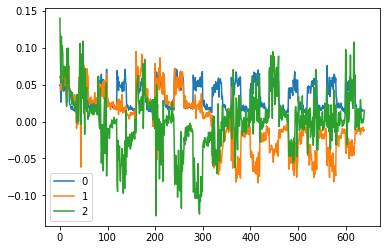

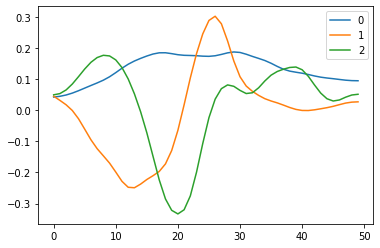

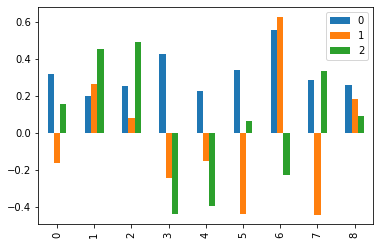

In [38]:
##Tensor decompositions: Tucker decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Lets input the EMG data across all trials, timepoints and muscles as a tensor into a Tucker decomposition.

#Firstly we reshape the data into 3 dimensions
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Then using the Tensorly package, use this tensor as input in the following manner:

core, factors_tuck = tucker(X_tensor ,rank=[num_components,num_components,num_components])

#This results in two outputs, a core and an array of factors. The factors are what we are interested in here as they
#represent the spatial, temporal and trial specific components of the original dataset

#We can also vary the number of the individual components we extract as shown below:

cores, factors = tucker(X_tensor ,rank=[3,3,4])

#To index into the factors array and find the components of interest, you can do so in the following manner:

factors[0]    #Trial-specific components
factors[1]    #Temporal components
factors[2]    #Spatial components


#Q11) Can you plot the output as shown above for PARAFAC??

pd.DataFrame(factors_tuck[0]).plot()
pd.DataFrame(factors_tuck[1]).plot()
pd.DataFrame(factors_tuck[2]).plot(kind='bar')

In [17]:
##Tensor decompositions: Non-negative Tucker
##http://tensorly.org/stable/user_guide/tensor_decomposition.html


#Try to replicate the above computation on a Tucker decomposition with non-negative constraints.

X_tensor=tl.tensor(X.values.reshape(640,50,9))
core, factors_nnt =non_negative_tucker(X_tensor ,rank=[num_components,num_components,num_components])


#Q12) What effect does this non-negativity have on the interpretability of the output??



Single iteration LDA Accuracy score:  0.9895833333333334


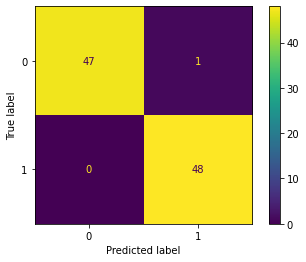

Cross validated score (Mean (Std)): 99.00% (7.00%)


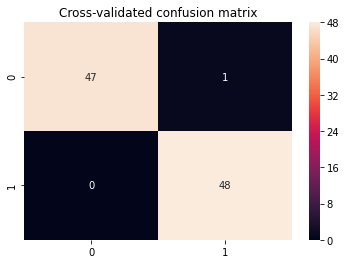

In [18]:
## Decode the task variable you selected using the underlying parameters trial-specific coefficients 
#from the above tensor decompositions
## For the Task1-16 variable, a decoding accuracy >1/16 is significant and so on for the other variables.
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008

#Here is an example implementation using Linear discriminant analysis on the Tucker decomposition output

#Split the trial-specific activation coefficients and the task variable into training and testing groups as follows:

X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],task,train_size=0.85,stratify=task)

#Adjust the training size above to whatever percentage you see fit...

#Initialise the LDA model
model=LDA()
#Fit the training data to the model
model.fit(X_train,y_train)

#Use the fitted model to task category of the unseen test data
y_pred=model.predict(X_test)
#Determine the accuracy score by constrasting the predictions against the actual task output
print('Single iteration LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_tuck=accuracy_score(y_test,y_pred)

#Plot a confusion matrix to show the true/false positives and negatives
plot_confusion_matrix(model,X_test,y_test)


#Always put the following statement at the end of a piece of code with plots 
plt.show()


#It is standard in the literature to cross-validate the accuracy of a model by shuffling the training/testing groups and
#fitting the model multiple times to find a stable average

#Initialise the number of folds (number of rounds) for cross-validation
kfold = KFold(n_splits=50, shuffle=True)

#This in-built function breaks the fitted training group into multiple sub-groups and finds a prediction of the unseen data
#based on these sub-groups
y_pred = cross_val_predict(model, X_test, y_test, cv=kfold)

#This in-build function provides an accuracy score for each round of cross-validation
results=cross_val_score(model, X_test, y_test, cv=kfold)
print("Cross validated score (Mean (Std)): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#We can plot the results of the cross_val_predict function against the true test values
conf=confusion_matrix(y_test,y_pred)
sns.heatmap(conf,annot=True).set_title('Cross-validated confusion matrix')
plt.show()




##Q13) Now carry out the above using the trial-specific components from different tensor decompositions

#Replace the 'factors_tuck[0]' in the train_test_split function above with one of the following:
    #factors_nntuck[0]
    #factors_nnpara[1][0]
    #factors_para[1][0]
    
##Q14) Once you have done that, try the same using different classifiers, for example:

    #Naive-Bayes
    #https://scikit-learn.org/stable/modules/naive_bayes.html
    
    #Replace 'LDA()' with GaussianNB()

    ##K-Nearest Neighbors
    ##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
    
    #Replace 'LDA()' with KNN()

In [19]:
#Q15) Can you find the tensor decomposition - classification model that gives the best output in terms of task discrimination??
    #Create a for loop that iterates over each tensor decomposition output from the model ranks 1-10 (num_components=1-10)
    #and classification model (LDA, GaussianNB and K-nearest neighbors) as the input parameter for each tensor decomposition 
    #and compute the task discrimination accuracy for all.

ranks=np.arange(1,11)
model1=LDA()
model2=GaussianNB()
model3=KNN()

models={model1,model2,model3}

Tucker_performance=[]
NNTucker_performance=[]
PARAFAC_performance=[]
NNPARAFAC_performance=[]
for i in ranks:
    core, factors_tuck = tucker(X_tensor ,rank=[i,i,i])
    core, factors_nnt =non_negative_tucker(X_tensor ,rank=[i,i,i])
    factors_nnpara = non_negative_parafac(X_tensor ,rank=i)
    factors_para = parafac(X_tensor ,rank=i)
    for model in models:
        X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],task,train_size=0.85,stratify=task)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        Tucker_performance.append(accuracy_score(y_test,y_pred))


        X_train, X_test, y_train, y_test=train_test_split(factors_nnt[0],task,train_size=0.85,stratify=task)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        NNTucker_performance.append(accuracy_score(y_test,y_pred))

        X_train, X_test, y_train, y_test=train_test_split(factors_para[1][0],task,train_size=0.85,stratify=task)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        PARAFAC_performance.append(accuracy_score(y_test,y_pred))

        X_train, X_test, y_train, y_test=train_test_split(factors_nnpara[1][0],task,train_size=0.85,stratify=task)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        NNPARAFAC_performance.append(accuracy_score(y_test,y_pred))